In [9]:
"""A very simple MNIST classifier.
based on tutorials https://www.tensorflow.org/get_started/mnist/beginners
and https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist
see Legal Notes at the end of the notebook
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import random

from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet

import tensorflow as tf

SOURCE_URL = 'https://storage.googleapis.com/cloud-deeplearning/kaggle_mnist_data/'
DOWNLOAD_DATASETS=True
DATA_DIR = '../input/'
KAGGLE_TRAIN_CSV = 'train.csv'
KAGGLE_TEST_CSV = 'test.csv'
SUBMISSION_FILE = 'submission_mnist_ann.csv'

# should sum up to 42000, the total number of images in train.csv
TRAIN_SIZE = 38000
VALID_SIZE = 2000
TEST_SIZE = 2000

In [10]:
# Can't use datasets from tensorflow tutorial, because the slicing of train, valid and test data differs from kaggle datasets
# TEMP_DIR = '/tmp/tensorflow/mnist/input_data'
# mnist = input_data.read_data_sets(TEMP_DIR, one_hot=True)

In [11]:
def custom_kaggle_mnist():
    """
    downloads and parses mnist train dataset for kaggle digit recognizer
    parsing and one_hot copied https://www.kaggle.com/kakauandme/tensorflow-deep-nn
    """
    if DOWNLOAD_DATASETS:
        base.maybe_download(KAGGLE_TRAIN_CSV, DATA_DIR, SOURCE_URL + KAGGLE_TRAIN_CSV)

    # Import data from datasource, see https://www.kaggle.com/kakauandme/tensorflow-deep-nn
    # read training data from CSV file 
    data = pd.read_csv(DATA_DIR + KAGGLE_TRAIN_CSV)
    
    from sklearn.utils import shuffle
    data = shuffle(data, random_state=42)
    
    images = data.iloc[:,1:].values
    images = images.astype(np.float)

    # convert from [0:255] => [0.0:1.0]
    images = np.multiply(images, 1.0 / 255.0)

    print('number of images in downloaded train dataset: {0[0]}'.format(images.shape))
    
    labels_flat = data.iloc[:,0].values
    labels_count = np.unique(labels_flat).shape[0]
    def dense_to_one_hot(labels_dense, num_classes):
        num_labels = labels_dense.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
        return labels_one_hot

    labels = dense_to_one_hot(labels_flat, labels_count)
    labels = labels.astype(np.uint8)

    # split data into training & validation
    mnist_train_images = images[:TRAIN_SIZE]
    mnist_train_labels = labels[:TRAIN_SIZE]
    print('number of train images: {0[0]}'.format(mnist_train_images.shape))

    mnist_valid_images = images[TRAIN_SIZE:TRAIN_SIZE + VALID_SIZE]
    mnist_valid_labels = labels[TRAIN_SIZE:TRAIN_SIZE + VALID_SIZE]
    print('number of valid images: {0[0]}'.format(mnist_valid_images.shape))

    mnist_test_images = images[TRAIN_SIZE + VALID_SIZE:images.shape[0]]
    mnist_test_labels = labels[TRAIN_SIZE + VALID_SIZE:images.shape[0]]
    print('number of test images: {0[0]}'.format(mnist_test_images.shape))
    
    options = dict(dtype=np.float, reshape=False, seed=42)

    train = DataSet(mnist_train_images, mnist_train_labels, options)
    valid = DataSet(mnist_valid_images, mnist_valid_labels, options)
    test = DataSet(mnist_test_images, mnist_test_labels, options)

    return base.Datasets(train=train, validation=valid, test=test)

In [6]:
mnist = custom_kaggle_mnist()

Successfully downloaded train.csv 76775041 bytes.


number of images in downloaded train dataset: 42000
number of train images: 38000
number of valid images: 2000
number of test images: 2000


In [18]:
def display_digit(image, label, num):
    """
    adapted from https://www.oreilly.com/learning/not-another-mnist-tutorial-with-tensorflow
    """
    image = image.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

def visualize_input(img):
    """
    taken from https://github.com/udacity/aind2-cnn/blob/master/mnist-mlp/mnist_mlp.ipynb
    """
    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

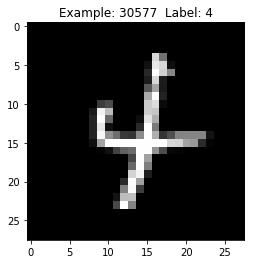

In [19]:
digit_index = random.randint(0, len(mnist.train.images))
display_digit(mnist.train.images[digit_index], mnist.train.labels[digit_index].argmax(), digit_index)

In [21]:
visualize_input(mnist.train.images[digit_index].reshape([28,28]))

In [22]:
# neural network with 1 layer of 10 softmax neurons
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784]        # 784 = 28 * 28
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (softmax)      W [784, 10]     b[10]
#   · · · · · · · ·                                              Y [batch, 10]

# The model is:
#
# Y = softmax( X * W + b)
#              X: matrix for 100 grayscale images of 28x28 pixels, flattened (there are 100 images in a mini-batch)
#              W: weight matrix with 784 lines and 10 columns
#              b: bias vector with 10 dimensions
#              +: add with broadcasting: adds the vector to each line of the matrix (numpy)
#              softmax(matrix) applies softmax on each line
#              softmax(line) applies an exp to each value then divides by the norm of the resulting line
#              Y: output matrix with 100 lines and 10 columns

X = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
Y = tf.nn.softmax(tf.matmul(X, W) + b)

# predictions will go here
Y_ = tf.placeholder(tf.float32, [None, 10])

In [16]:
# Exercise: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/#6

# neural network with 2 layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]   # 784 = 28*28
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 225]      B1[225]
#  · · · · · · · · ·                                                Y1 [batch, 225]
#   \x/x\x/x\x/x\x/         -- fully connected layer (softmax)      W2 [225, 10]        B2[10]
#    · · · · · · ·                                                  Y [batch, 10]

In [23]:
cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y)) * 1000.0  # normalized for batches of 100 images,
                                                          # *10 because  "mean" included an unwanted division by 10
train_step = tf.train.GradientDescentOptimizer(0.005).minimize(cross_entropy)

In [24]:
sess = tf.InteractiveSession()

In [25]:
tf.global_variables_initializer().run()
# Train (10, 100, 1000)
for index in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={X: batch_xs, Y_: batch_ys})

In [26]:
# Validate trained model
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={X: mnist.validation.images,
                                    Y_: mnist.validation.labels}))

0.9075


In [ ]:
def show_wrong_validation():
  """
  from http://euler.stat.yale.edu/~tba3/stat665/lectures/lec17/notebook17.html
  """
  predictions = sess.run(tf.argmax(tf.nn.softmax(Y), 1), feed_dict={X: mnist.validation.images})

  valid_labels = sess.run(tf.argmax(mnist.validation.labels, 1))

  wrong_valid = [im for im in zip(mnist.validation.images, predictions, valid_labels) if im[1] != im[2]]

  print('{0} out of {1} validation images were classified incorrectly'.format(len(wrong_valid), mnist.validation.images.shape[0]))

  plt.figure(figsize=(10, 10))
  for ind, val in enumerate(wrong_valid[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1.2)
    plt.subplot(10, 10, ind + 1)
    im = val[0].reshape((28,28))
    plt.axis("off")
    plt.text(0, -2, val[2], fontsize=14, color='blue')
    plt.text(8, -2, val[1], fontsize=14, color='red')
    plt.imshow(im, cmap=plt.get_cmap('gray'))
  plt.show()

In [27]:
show_wrong_validation()

NameError: name 'show_wrong_validation' is not defined

In [29]:
# trained weights
def show_trained_weights():
  """
  from https://www.oreilly.com/learning/not-another-mnist-tutorial-with-tensorflow
  """
  for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = sess.run(W)[:,i]
    plt.title(i)
    plt.imshow(weight.reshape([28,28]), cmap=plt.get_cmap('gray'))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
  plt.show()

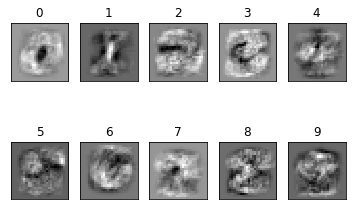

In [30]:
show_trained_weights()

In [31]:
weights_0 = sess.run(W)[:,0].reshape([28,28])
visualize_input(weights_0)

In [32]:
# Test trained model before submission
print(sess.run(accuracy, feed_dict={X: mnist.test.images,
                                    Y_: mnist.test.labels}))

0.915


In [33]:
# kaggle test data
if DOWNLOAD_DATASETS:
    base.maybe_download(KAGGLE_TEST_CSV, DATA_DIR, SOURCE_URL + KAGGLE_TEST_CSV)
kaggle_test_images = (pd.read_csv(DATA_DIR + KAGGLE_TEST_CSV).values).astype('float32')

predictions_kaggle = sess.run(tf.argmax(tf.nn.softmax(Y), 1), feed_dict={X: kaggle_test_images})

Successfully downloaded test.csv 51118296 bytes.


In [34]:
with open(SUBMISSION_FILE, 'w') as submission:
  submission.write('ImageId,Label\n')
  for index, prediction in enumerate(predictions_kaggle):
    submission.write('{0},{1}\n'.format(index + 1, prediction))
  print("prediction submission written to {0}".format(SUBMISSION_FILE))

prediction submission written to submission_mnist_ann.csv


In [ ]:
# some interesting images from test set: 181, 3967, 18690, 4765, 12086
test_rand = random.randint(0, len(kaggle_test_images))
display_digit(kaggle_test_images[test_rand], predictions_kaggle[test_rand], test_rand)

In [ ]:
# Legal Notes:

# Copyrights and Licenses:

# for https://www.github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/examples/tutorials/mnist/mnist_softmax.py:
#
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# for https://github.com/martin-gorner/tensorflow-mnist-tutorial/blob/master/mnist_1.0_softmax.py
# 
# Copyright 2016 Google.com
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.